# 1. Θεωρητικό Μέρος

α) Σύμφωνα με το paper, η τιμή της παραμέτρου 'α' καθορίζει το μέγεθος των πληροφοριών υψηλής συχνότητας που αφαιρείται από κάθε επίπεδο της πυραμίδας. Ειδικότερα, όσο πιο μεγάλη η τιμή του 'α', τόσο περισσότερες πληροφορίες υψηλής συχνότητας θα κόβουμε σε κάθε επίπεδο, οδηγώντας σε πιο καθαρή εικόνα. Αυτό είναι πολύ χρήσιμο σε εφαρμογές συμπίεσης εικόνας.

β) Εντροπία ορίζεται ως ο ελάχιστος αριθμός bits ανά pixel που χρειάζεται για ακριβής κωδικοποίηση της εικόνας, αν υποθέσουμε ότι οι τιμές των pixel μιας αναπαράστασης εικόνας είναι στατιστικά ανεξάρτητες. Η μέγιστη τιμή σύμφωνα με την εξίσωση του paper είναι H = log2(256) = 8

γ) Tο μέγεθος του bin σε ένα δεδομένο επίπεδο της πυραμίδας επηρεάζει το trade-off ποιότητας-μεγέθους. Πιο συγκεκριμένα, όσο πιο μεγάλο είναι το bin size, τόσο πιο μικρή είναι η ποιότητα της εικόνας, και τόσο λιγότεροι υπολογιστικοί πόροι απαιτούνται. Αντίθετα, όσο πιο μικρότερο το bin size, η ποιότητα της εικόνας βελτιώνεται, αλλά καταλαμβάνει περισσότερους υπολογιστικούς πόρους.

δ) Όσα περισσότερα επίπεδα υπάρχουν στην πυραμίδα, τόσο πιο "καθαρή" θα είναι η εικόνα, ωστόσο θα πρέπει να επιλεχθεί και το κατάλληλο bin size για να μην υπάρξουν απώλειες.

# 2. Εργαστηριακό Μέρος

Α) Υλοποίηση Αλγορίθμου

In [ ]:
import numpy as np

α) GKERNEL(a)

In [ ]:
def GKernel(a):
    # Create a 5x5 grid of coordinates centered at (2, 2)
    x, y = np.meshgrid(np.arange(5), np.arange(5))
    x -= 2
    y -= 2

    # Calculate the Gaussian kernel using the formula from the article
    kernel = np.exp(-(x**2 + y**2) / (2 * a**2))

    # Normalize the kernel so its sum is 1
    kernel /= np.sum(kernel)

    return kernel

β) l_out = GREDUCE(l, h)

In [ ]:
def GREDUCE(image, kernel):
    if len(image.shape) == 2:
        # If the input image is grayscale, convert it to a color image with 3 channels
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

    # Rest of the code remains the same
    padded = cv2.copyMakeBorder(image, 2, 2, 2, 2, cv2.BORDER_DEFAULT)
    blurred = np.zeros_like(image)
    for c in range(3):
        for i in range(blurred.shape[0]):
            for j in range(blurred.shape[1]):
                patch = padded[i:i+5, j:j+5, c]
                blurred[i, j, c] = np.sum(patch * kernel)
    downsampled = blurred[::2, ::2, :]

    return downsampled


γ) G = GPyramid(l, a, depth)

In [ ]:
def GPyramid(image, a, depth):
    pyramid = []
    kernel = GKernel(a)
    pyramid.append(image)
    for i in range(depth):
        image = GREDUCE(image, kernel)
        kernel = GKernel(a * 2**(i+1))  # update kernel size
        pyramid.append(image)
    return pyramid

δ)  I_out = GEXPAND(I, h)

In [ ]:
def GEXPAND(image, kernel):
    # Convert grayscale images to color images with 3 channels
    if len(image.shape) == 2:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

    # Upsample the image using bilinear interpolation
    h, w, c = image.shape
    new_h, new_w = h * 2, w * 2
    new_image = np.zeros((new_h, new_w, c), dtype=np.float32)
    for k in range(c):
        for i in range(new_h):
            for j in range(new_w):
                x, y = j / 2, i / 2
                x1, y1 = int(x), int(y)
                x2, y2 = min(x1 + 1, w - 1), min(y1 + 1, h - 1)
                fx, fy = x - x1, y - y1
                f1 = (1 - fx) * image[y1, x1, k] + fx * image[y1, x2, k]
                f2 = (1 - fx) * image[y2, x1, k] + fx * image[y2, x2, k]
                new_image[i, j, k] = (1 - fy) * f1 + fy * f2

    # Convolve the upsampled image with the Gaussian kernel
    padded = np.pad(new_image, ((2, 2), (2, 2), (0, 0)), mode='reflect')  # Change padding mode to 'edge'
    convolved = np.zeros_like(new_image)
    for k in range(c):  # Loop over channels for color images
        for i in range(convolved.shape[0]):
            for j in range(convolved.shape[1]):
                patch = padded[i:i+5, j:j+5, k]
                convolved[i, j, k] = np.sum(patch * kernel)

    return convolved

ε) L = LPyramid(I, a, depth)

In [ ]:
def LPyramid(image, a, depth):
    # Convert grayscale images to color images with 3 channels
    if len(image.shape) == 2:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

    G = GPyramid(image, a, depth)
    L = [G[depth-1]]
    for i in range(depth-2, -1, -1):
        expanded = GEXPAND(G[i+1], GKernel(a))
        laplacian = G[i] - expanded[:G[i].shape[0], :G[i].shape[1], :]
        L.append(laplacian)
    L.reverse()
    return L


στ) I_out = L_Pyramid_Decode(L,a)

In [ ]:
def L_Pyramid_Decode(L, a):
    # Define the Gaussian kernel for expansion
    kernel_expand = GKernel(a * 2)

    # Start with the lowest resolution image
    image = L[-1]

    # Iterate through the Laplacian pyramid in reverse order
    for i in range(len(L) - 2, -1, -1):
        # Expand the image to the next level
        image = GEXPAND(image, kernel_expand)

        # Add the Laplacian image to the expanded image
        image += L[i]

    # Define the Gaussian kernel for final smoothing
    kernel_smooth = GKernel(a)

    # Smooth the final image
    image_smooth = cv2.filter2D(image, -1, kernel_smooth)

    # Clip and convert the image back to uint8
    image_smooth = np.clip(image_smooth, 0, 255).astype(np.uint8)

    return image_smooth


ζ) L_Quantization (το θελει χωρις params(??))

In [ ]:
def L_Quantization(img, bin_size):

    # Downsize the image until the dimensions are equal to or lower than bin_size
    copy = img.copy()
    while min(copy.shape) > bin_size:
        copy = cv2.pyrDown(copy)

    # Compute the depth of the Laplacian pyramid based on the bin size
    depth = int(np.log2(copy.shape[0])) + 1

    # Compute the Laplacian pyramid of the downsampled image
    L = LPyramid(img, 0.7, depth)

    # Quantize each level of the Laplacian pyramid
    for i in range(depth):
        L[i] = np.floor_divide(L[i], 256 // bin_size) * (256 // bin_size)

    # Reconstruct the quantized image from the Laplacian pyramid
    reconstructed_img = L_Pyramid_Decode(L, 0.7)

    return reconstructed_img

**B. Δοκιμές αλγορίθμου**

α)

In [ ]:
import urllib.request
import cv2
from matplotlib import pyplot as plt
from skimage import data
%matplotlib inline
# Load the images from URL
lena = urllib.request.urlopen('http://www.image.ntua.gr/~tpar/LABimage/lena.png')
lena_img = np.asarray(bytearray(lena.read()), dtype=np.uint8)
lena_img = cv2.imdecode(lena_img, -1)
lena_img = cv2.cvtColor(lena_img, cv2.COLOR_BGR2RGB)  # convert to RGB format

camera_img = data.camera()

Function tests

Entropy of the original image: 7.445507322798073 bits
Entropy of the decoded image: 7.31410536554732 bits


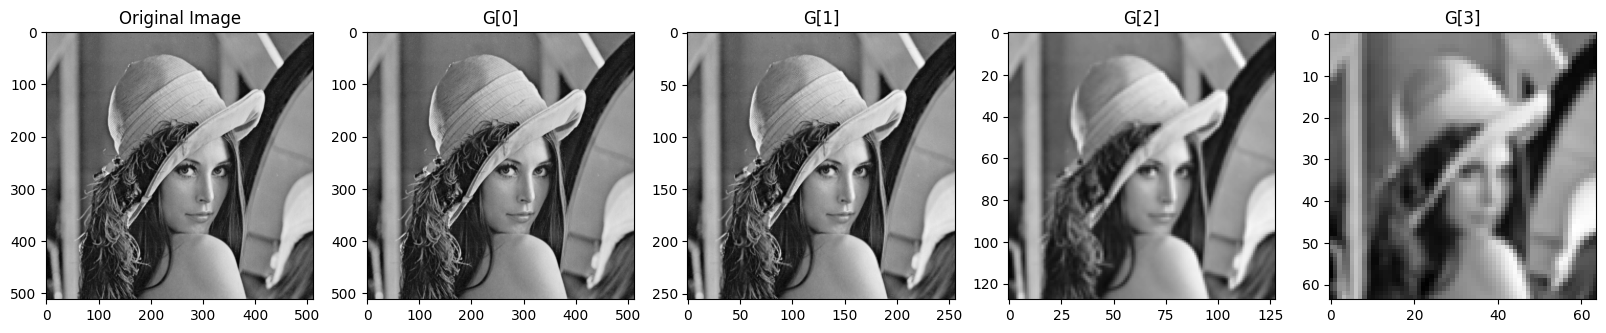

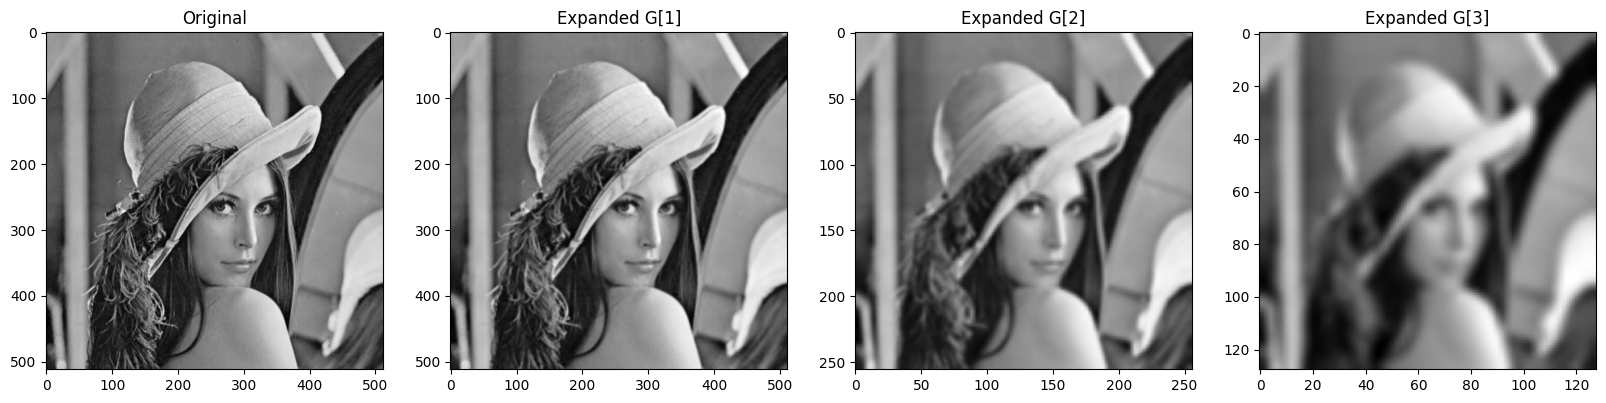

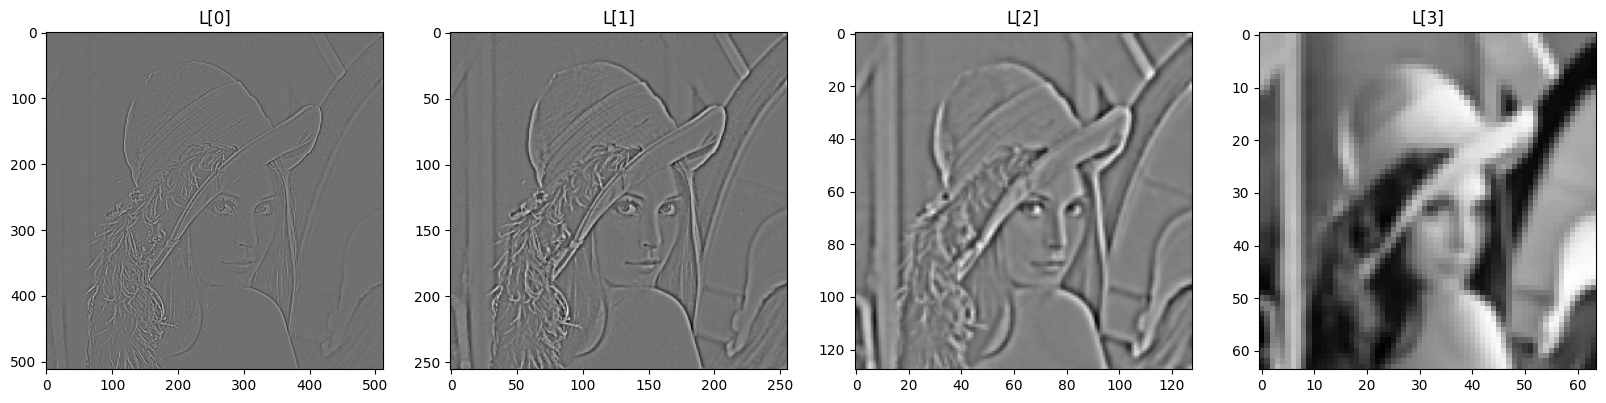

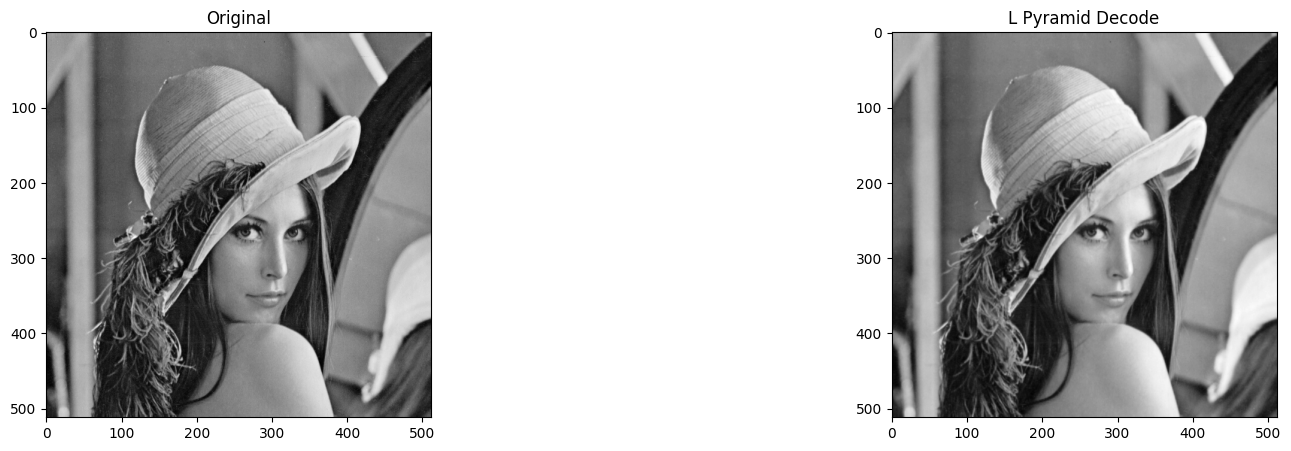

In [ ]:
# Define the Laplacian pyramid parameters
a = 0.6
depth = 4
G = GPyramid(lena_img, a, depth)

expanded_g1 = GEXPAND(G[1], GKernel(a))
expanded_g2 = GEXPAND(G[2], GKernel(a))
expanded_g3 = GEXPAND(G[3], GKernel(a))
Y0 = cv2.cvtColor(lena_img, cv2.COLOR_RGB2YCrCb)[:,:,0]
Y1 = cv2.cvtColor(expanded_g1, cv2.COLOR_RGB2YCrCb)[:,:,0]
Y2 = cv2.cvtColor(expanded_g2, cv2.COLOR_RGB2YCrCb)[:,:,0]
Y3 = cv2.cvtColor(expanded_g3, cv2.COLOR_RGB2YCrCb)[:,:,0]
Y4 = cv2.cvtColor(G[0], cv2.COLOR_RGB2YCrCb)[:,:,0]
Y5 = cv2.cvtColor(G[1], cv2.COLOR_RGB2YCrCb)[:,:,0]
Y6 = cv2.cvtColor(G[2], cv2.COLOR_RGB2YCrCb)[:,:,0]
Y7 = cv2.cvtColor(G[3], cv2.COLOR_RGB2YCrCb)[:,:,0]
fig, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(1, 5, figsize=(20, 5))
ax0.imshow(Y0, cmap="gray")
ax0.set_title("Original Image")
ax1.imshow(Y4, cmap="gray")
ax1.set_title("G[0]")
ax2.imshow(Y5, cmap="gray")
ax2.set_title("G[1]")
ax3.imshow(Y6, cmap="gray")
ax3.set_title("G[2]")
ax4.imshow(Y7, cmap="gray")
ax4.set_title("G[3]")

fig2, (ax5, ax6, ax7, ax8) = plt.subplots(1, 4, figsize=(20, 5))
ax5.imshow(Y0, cmap="gray")
ax5.set_title("Original")
ax6.imshow(Y1, cmap="gray")
ax6.set_title("Expanded G[1]")
ax7.imshow(Y2, cmap="gray")
ax7.set_title("Expanded G[2]")
ax8.imshow(Y3, cmap="gray")
ax8.set_title("Expanded G[3]")

L = LPyramid(lena_img, a, depth)
Y8 = cv2.cvtColor(L[0], cv2.COLOR_RGB2YCrCb)[:,:,0]
Y9 = cv2.cvtColor(L[1], cv2.COLOR_RGB2YCrCb)[:,:,0]
Y10 = cv2.cvtColor(L[2], cv2.COLOR_RGB2YCrCb)[:,:,0]
Y11 = cv2.cvtColor(L[3], cv2.COLOR_RGB2YCrCb)[:,:,0]
fig3, (ax9, ax10, ax11, ax12) = plt.subplots(1, 4, figsize=(20, 5))
ax9.imshow(Y8, cmap="gray")
ax9.set_title("L[0]")
ax10.imshow(Y9, cmap="gray")
ax10.set_title("L[1]")
ax11.imshow(Y10, cmap="gray")
ax11.set_title("L[2]")
ax12.imshow(Y11, cmap="gray")
ax12.set_title("L[3]")
img3 = L_Pyramid_Decode(L, a)
Y12 = cv2.cvtColor(img3, cv2.COLOR_RGB2YCrCb)[:,:,0]
fig4, (ax13, ax14) = plt.subplots(1, 2, figsize=(20, 5))
ax13.imshow(Y0, cmap="gray")
ax13.set_title("Original")
ax14.imshow(Y12, cmap="gray")
ax14.set_title("L Pyramid Decode")

# Convert the image to grayscale
orgnl = cv2.cvtColor(lena_img, cv2.COLOR_RGB2GRAY)
decoded = cv2.cvtColor(img3, cv2.COLOR_RGB2GRAY)

eps = 1e-10  # small epsilon value
hist_orgnl, _ = np.histogram(orgnl, bins=256, range=(0, 255))
hist_decoded, _ = np.histogram(decoded, bins=256, range=(0, 255))
prob1 = (hist_orgnl + eps) / np.sum(hist_orgnl + eps)
prob2 = (hist_decoded + eps) / np.sum(hist_decoded + eps)
entropy1 = -np.sum(prob1 * np.log2(prob1))
entropy2 = -np.sum(prob2 * np.log2(prob2))

print("Entropy of the original image:", entropy1, "bits")
print("Entropy of the decoded image:", entropy2, "bits")

β)

Entropy of the original lena image: 7.445507322798073 bits
Entropy of the original camera image: 7.23169501105588 bits


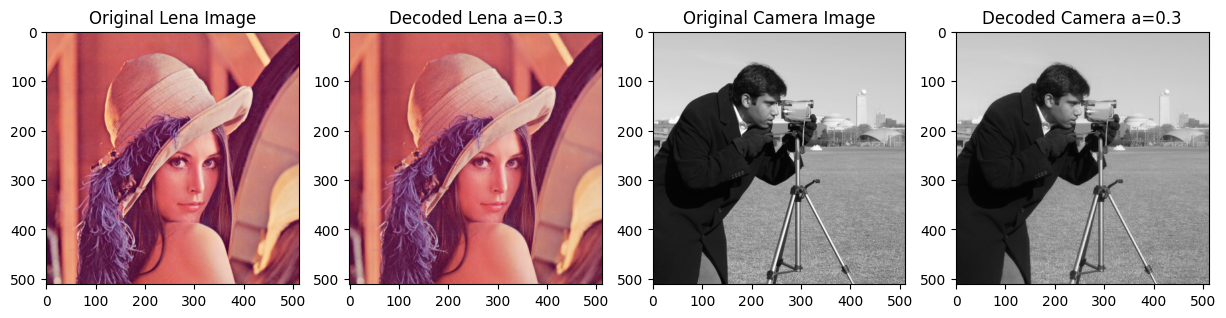

Entropy of the decoded lena image with a = 0.3 : 7.361555393429123 bits
Entropy of the decoded camera image with a = 0.3 : 7.202404898959613 bits


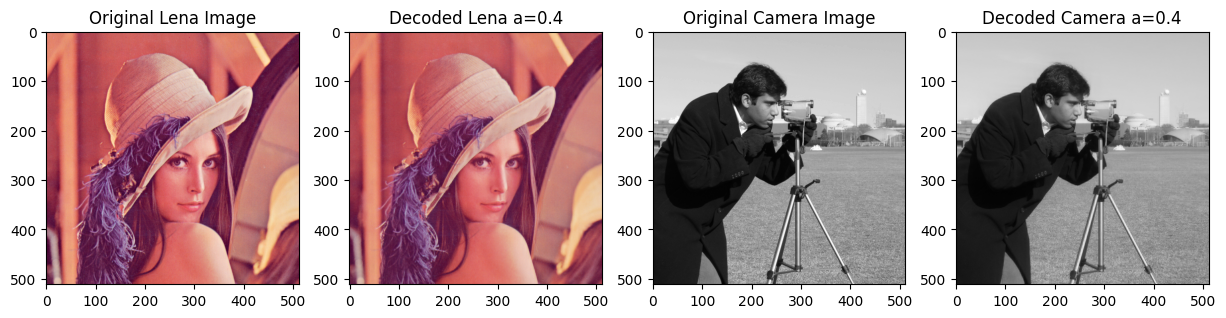

Entropy of the decoded lena image with a = 0.4 : 7.323697935043469 bits
Entropy of the decoded camera image with a = 0.4 : 7.167413830863871 bits


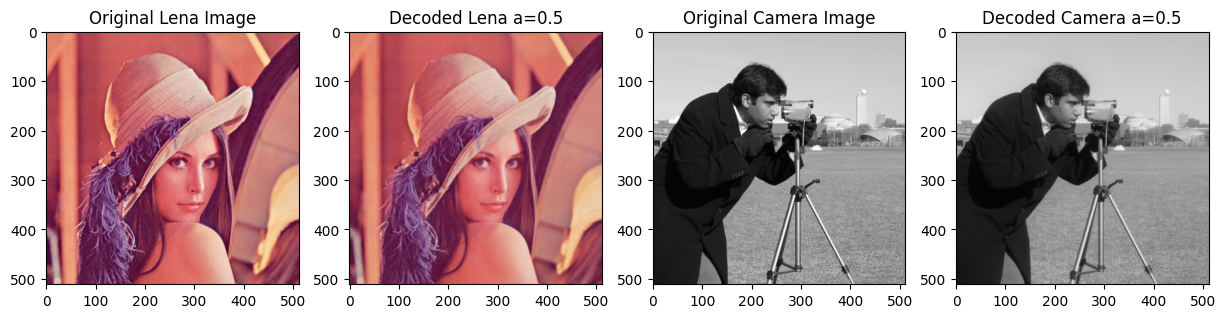

Entropy of the decoded lena image with a = 0.5 : 7.294971855847841 bits
Entropy of the decoded camera image with a = 0.5 : 7.117242606010162 bits


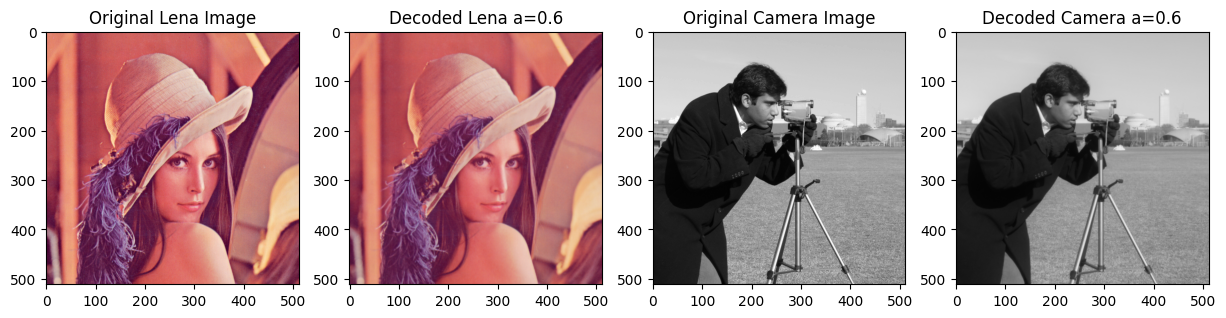

Entropy of the decoded lena image with a = 0.6 : 7.279160559473921 bits
Entropy of the decoded camera image with a = 0.6 : 7.078768844885228 bits


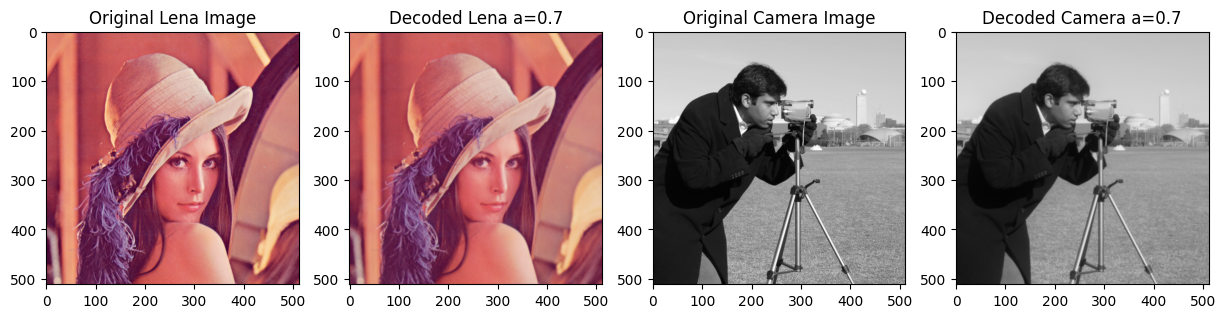

Entropy of the decoded lena image with a = 0.7 : 7.273451495529378 bits
Entropy of the decoded camera image with a = 0.7 : 7.055375081051324 bits


In [ ]:
def calculate_entropy(img):
    # Convert image to YCbCr color space
    img_ycbcr = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    y_channel = img_ycbcr[:, :, 0]

    # Compute histogram and probability distribution
    hist, _ = np.histogram(y_channel, bins=256, range=(0, 255))
    eps = np.finfo(float).eps
    prob = (hist + eps) / np.sum(hist + eps)

    # Compute entropy
    entropy = -np.sum(prob * np.log2(prob))

    return entropy

a = [0.3, 0.4, 0.5, 0.6, 0.7]
depth = 5
lena_entropy_a = []
camera_entropy_a = []

lena_gray = cv2.cvtColor(lena_img, cv2.COLOR_RGB2GRAY)
temp = cv2.cvtColor(camera_img, cv2.COLOR_BGR2RGB)
camera_gray = cv2.cvtColor(temp, cv2.COLOR_RGB2GRAY)

eps = 1e-10  # small epsilon value
hist_lena, _ = np.histogram(lena_gray, bins=256, range=(0, 255))
hist_camera, _ = np.histogram(camera_gray, bins=256, range=(0, 255))
prob1 = (hist_lena + eps) / np.sum(hist_lena + eps)
prob2 = (hist_camera + eps) / np.sum(hist_camera + eps)
entropy1 = -np.sum(prob1 * np.log2(prob1))
entropy2 = -np.sum(prob2 * np.log2(prob2))
print("Entropy of the original lena image:", entropy1, "bits")
print("Entropy of the original camera image:", entropy2, "bits")

for i in range(len(a)):
  # Lena
  L_lena = LPyramid(lena_img, a[i], depth)
  lena_decoded = L_Pyramid_Decode(L_lena, a[i])

  # Camera
  L_camera = LPyramid(camera_img, a[i], depth)
  camera_decoded = L_Pyramid_Decode(L_camera, a[i])

  fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15, 5))
  Y1 = lena_decoded
  Y2 = camera_decoded
  Y1 = Y1 / 255.0
  Y1 = np.clip(Y1, 0, 1)
  Y2 = Y2 / 255.0
  Y2 = np.clip(Y2, 0, 1)
  ax1.imshow(lena_img)
  ax1.set_title("Original Lena Image")
  string = "Decoded Lena a=" + str(a[i])
  ax2.imshow(Y1)
  ax2.set_title(string)
  ax3.imshow(camera_img, cmap="gray")
  ax3.set_title("Original Camera Image")
  string = "Decoded Camera a=" + str(a[i])
  ax4.imshow(Y2)
  ax4.set_title(string)
  plt.show()

  lena_entropy_a.append(calculate_entropy(lena_decoded))
  camera_entropy_a.append(calculate_entropy(camera_decoded))
  # Convert the image to grayscale
  lena_decoded_gray = cv2.cvtColor(lena_decoded, cv2.COLOR_RGB2GRAY)
  camera_decoded_gray = cv2.cvtColor(camera_decoded, cv2.COLOR_RGB2GRAY)
  print("Entropy of the decoded lena image with a =", a[i], ":", calculate_entropy(lena_decoded), "bits")
  print("Entropy of the decoded camera image with a =", a[i], ":", calculate_entropy(camera_decoded), "bits")

γ)

Entropy of the original lena image: 7.445507322798073 bits
Entropy of the original camera image: 7.23169501105588 bits


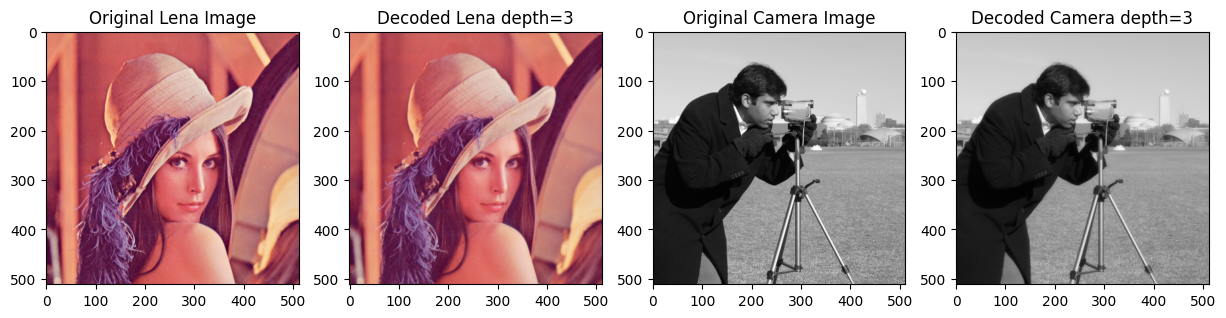

Entropy of the decoded lena image with depth = 3 : 7.367527368787168 bits
Entropy of the decoded camera image with depth = 3 : 7.13284593925502 bits


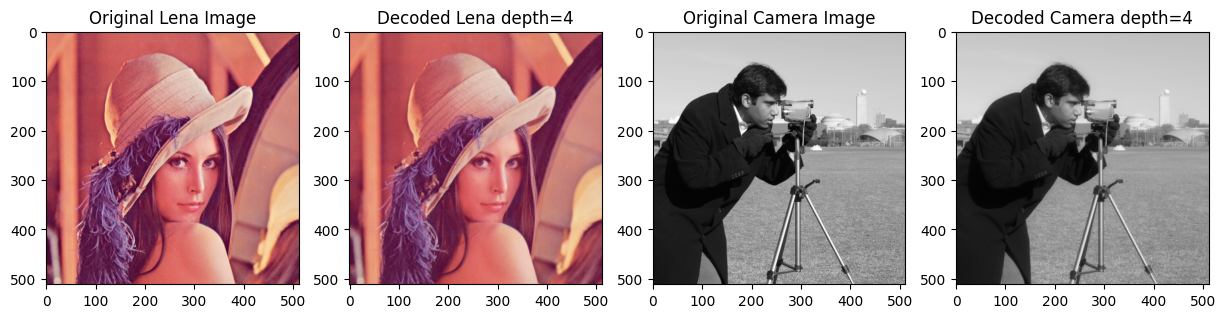

Entropy of the decoded lena image with depth = 4 : 7.326874833812995 bits
Entropy of the decoded camera image with depth = 4 : 7.130602517620442 bits


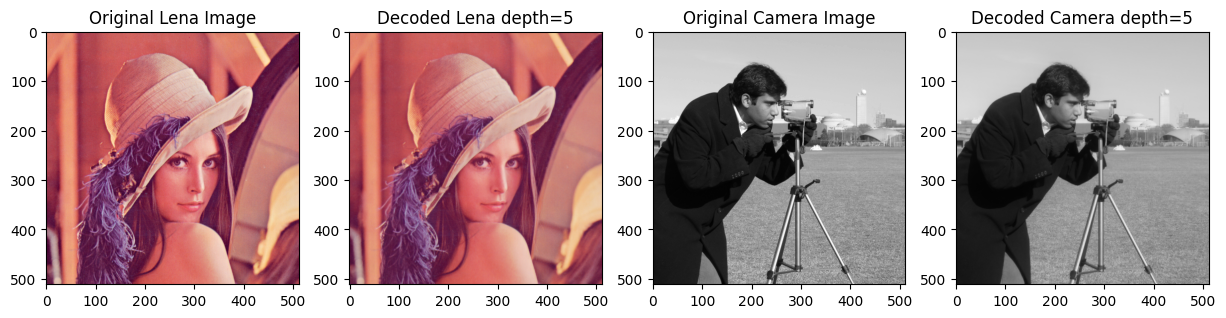

Entropy of the decoded lena image with depth = 5 : 7.29500039177028 bits
Entropy of the decoded camera image with depth = 5 : 7.11724260601054 bits


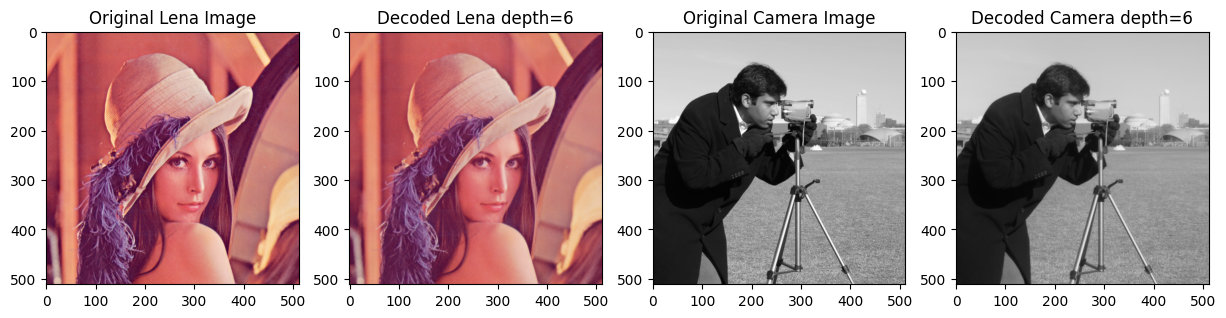

Entropy of the decoded lena image with depth = 6 : 7.271722632301718 bits
Entropy of the decoded camera image with depth = 6 : 7.068694862504578 bits


In [ ]:
a = 0.5
depth = [3, 4, 5, 6]
lena_entropy_depth = []
camera_entropy_depth = []

lena_gray = cv2.cvtColor(lena_img, cv2.COLOR_RGB2GRAY)
temp = cv2.cvtColor(camera_img, cv2.COLOR_BGR2RGB)
camera_gray = cv2.cvtColor(temp, cv2.COLOR_RGB2GRAY)

eps = 1e-10  # small epsilon value
hist_lena, _ = np.histogram(lena_gray, bins=256, range=(0, 255))
hist_camera, _ = np.histogram(camera_gray, bins=256, range=(0, 255))
prob1 = (hist_lena + eps) / np.sum(hist_lena + eps)
prob2 = (hist_camera + eps) / np.sum(hist_camera + eps)
entropy1 = -np.sum(prob1 * np.log2(prob1))
entropy2 = -np.sum(prob2 * np.log2(prob2))
print("Entropy of the original lena image:", entropy1, "bits")
print("Entropy of the original camera image:", entropy2, "bits")

for i in range(len(depth)):
  # Lena
  L_lena = LPyramid(lena_img, a, depth[i])
  lena_decoded = L_Pyramid_Decode(L_lena, a)

  # Camera
  L_camera = LPyramid(camera_img, a, depth[i])
  camera_decoded = L_Pyramid_Decode(L_camera, a)

  fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15, 5))
  Y1 = lena_decoded
  Y2 = camera_decoded
  Y1 = Y1 / 255.0
  Y1 = np.clip(Y1, 0, 1)
  Y2 = Y2 / 255.0
  Y2 = np.clip(Y2, 0, 1)
  ax1.imshow(lena_img)
  ax1.set_title("Original Lena Image")
  string = "Decoded Lena depth=" + str(depth[i])
  ax2.imshow(Y1)
  ax2.set_title(string)
  ax3.imshow(camera_img, cmap="gray")
  ax3.set_title("Original Camera Image")
  string = "Decoded Camera depth=" + str(depth[i])
  ax4.imshow(Y2)
  ax4.set_title(string)
  plt.show()

  # Convert the image to grayscale
  lena_decoded_gray = cv2.cvtColor(lena_decoded, cv2.COLOR_RGB2GRAY)
  camera_decoded_gray = cv2.cvtColor(camera_decoded, cv2.COLOR_RGB2GRAY)

  hist_lena_decoded, _ = np.histogram(lena_decoded_gray, bins=256, range=(0, 255))
  hist_camera_decoded, _ = np.histogram(camera_decoded_gray, bins=256, range=(0, 255))

  prob3 = (hist_lena_decoded + eps) / np.sum(hist_lena_decoded + eps)
  prob4 = (hist_camera_decoded + eps) / np.sum(hist_camera_decoded + eps)
  entropy3 = -np.sum(prob3 * np.log2(prob3))
  entropy4 = -np.sum(prob4 * np.log2(prob4))
  lena_entropy_depth.append(entropy3)
  camera_entropy_depth.append(entropy4)

  print("Entropy of the decoded lena image with depth =", depth[i], ":", entropy3, "bits")
  print("Entropy of the decoded camera image with depth =", depth[i], ":", entropy4, "bits")

δ)

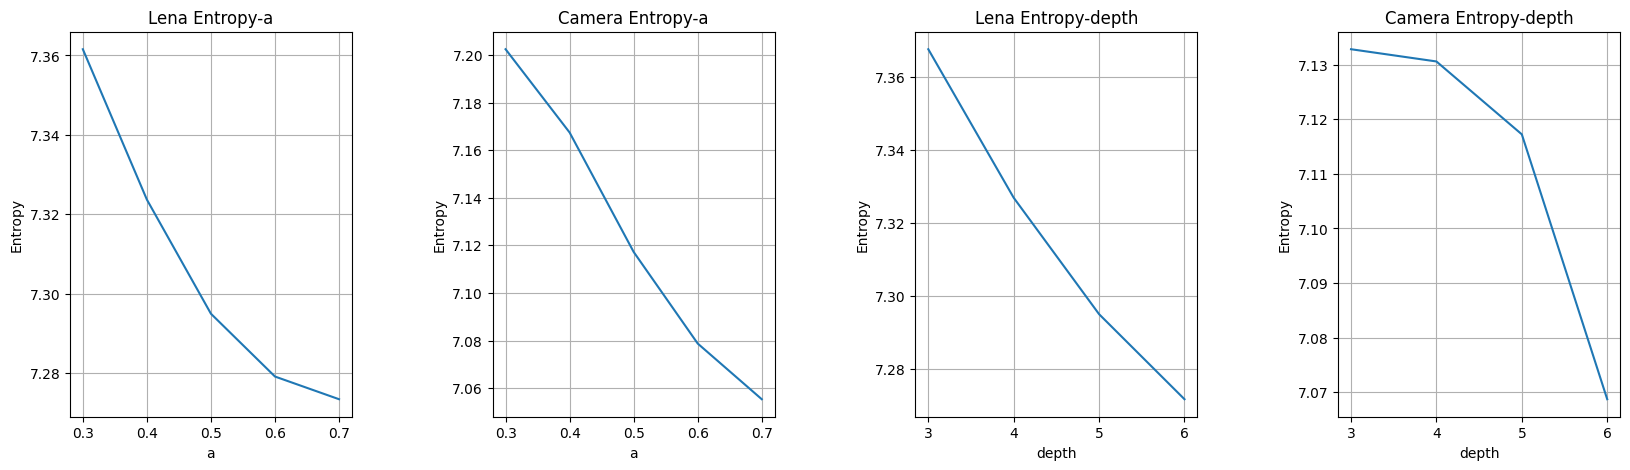

In [ ]:
a = [0.3, 0.4, 0.5, 0.6, 0.7]
depth = [3, 4, 5, 6]

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 5))
ax1.grid(True)
ax2.grid(True)
ax3.grid(True)
ax4.grid(True)

ax1.plot(a, lena_entropy_a)
ax1.set_title('Lena Entropy-a')
ax1.set_xlabel('a')
ax1.set_ylabel('Entropy')

ax2.plot(a, camera_entropy_a)
ax2.set_title('Camera Entropy-a')
ax2.set_xlabel('a')
ax2.set_ylabel('Entropy')

ax3.plot(depth, lena_entropy_depth)
ax3.set_title('Lena Entropy-depth')
ax3.set_xlabel('depth')
ax3.set_ylabel('Entropy')

ax4.plot(depth, camera_entropy_depth)
ax4.set_title('Camera Entropy-depth')
ax4.set_xlabel('depth')
ax4.set_ylabel('Entropy')

plt.subplots_adjust(wspace=0.5)
plt.show()

ε) Με βάση τα γραφήματα των original και αποκωδικοποιημένων εικονών, βρήκαμε πως για την lena το καλύτερο a είναι 0.7 και το depth 6, ενώ για την camera το a 0.7 με depth 6. Θεωρητικά περιμέναμε το βέλτιστο a να κυμαίνεται μεταξύ 0.5-0.6 για την Lena. Μικροδιαφορές μπορεί να οφείλονται σε τυχόν θόρυβο και διαφορές στον τρόπο υπολογισμού της εντροπίας.

στ)

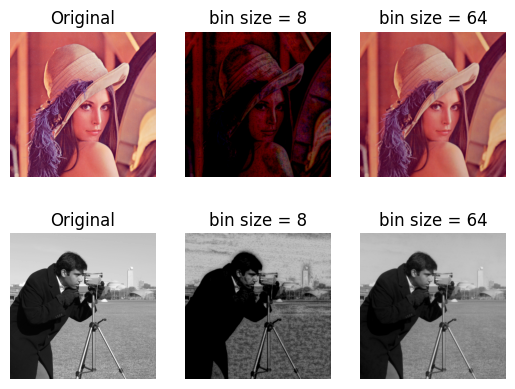

In [ ]:
# The optimal a for the Lena image
a = 0.7

# Quantize the Lena image with different bin sizes
lena_q1 = L_Quantization(lena_img, 8)
lena_q2 = L_Quantization(lena_img, 64)

# Quantize the camera image with different bin sizes
camera_q1 = L_Quantization(camera_img, 8)
camera_q2 = L_Quantization(camera_img, 64)

# Display the original and quantized images
fig, axs = plt.subplots(2, 3)

axs[0, 0].imshow(lena_img, cmap='gray')
axs[0, 0].set_title('Original')

axs[0, 1].imshow(lena_q1, cmap='gray')
axs[0, 1].set_title('bin size = 8')

axs[0, 2].imshow(lena_q2, cmap='gray')
axs[0, 2].set_title('bin size = 64')

axs[1, 0].imshow(camera_img, cmap='gray')
axs[1, 0].set_title('Original')

axs[1, 1].imshow(camera_q1, cmap='gray')
axs[1, 1].set_title('bin size = 8')

axs[1, 2].imshow(camera_q2, cmap='gray')
axs[1, 2].set_title('bin size = 64')

for ax in axs.flat:
    ax.axis('off')

plt.show()